**Trabalho Final da Disciplina Processamento de Linguagem Natural**

Aluno: Victor Hugo Brito da Silva Miranda

Professor: Daniel Xavier de Sousa

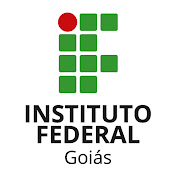

**O trabalho**

  Para o desenvolvimento do trabalho o artigo *Ensemble of Generative and Discriminative Techniques for Sentiment Analysis of Movie Reviews* (Conjunto de técnicas gerativas e discriminativas para análise de sentimento de resenhas de filmes) foi escolhido.

**Resumo**

A análise de sentimentos é uma tarefa comum no processamento de linguagem natural que visa detectar a polaridade de um documento de texto (normalmente uma avaliação de consumidor).
Nas configurações mais simples, discriminamos apenas entre sentimentos positivos e negativos, transformando a tarefa em um problema de classificação binária padrão.
No artigo foi comparado várias abordagens de aprendizado de máquina para esse problema e as combinamos para obter os melhores resultados possíveis.
Obtemos resultados fortes em um conjunto de dados bem conhecido de classificações de filmes do IMDB.


Link do artigo: https://paperswithcode.com/paper/ensemble-of-generative-and-discriminative

**Foram utilizados os seguintes Dados**

IMDb Movie Reviews Dataset: Contém 50.000 resenhas de filmes do IMDb, divididas igualmente entre positivas e negativas. Está disponível no link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Sentiment140: Conjunto de dados de tweets, onde cada tweet é rotulado com positivo, negativo ou neutro. O dataset contém 1.6 milhões de tweets com rótulos de sentimento. Disponível no link: https://www.kaggle.com/datasets/kazanova/sentiment140


In [1]:
# Instalar bibliotecas necessárias
!pip install gensim
!pip install transformers
!pip install torch
!pip install seaborn
# Instalação do pacote emoji (caso necessário)
!pip install emoji
!pip install nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.6 MB/s eta 0:00:00


In [57]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Download de recursos NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Leitura do DataSet

In [62]:
# Carregar dados IMDb
imdb_data = pd.read_csv('/content/drive/MyDrive/Dados Compartilhados - f250/IFG/pln/IMDB Dataset.csv')
imdb_data = imdb_data.sample(n=1000, random_state=42) # Limitar a 5000 registros para evitar sobrecarga

print("Primeiras linhas do dataset IMDb:")
print(imdb_data.head())


Primeiras linhas do dataset IMDb:
                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative


In [63]:

# Carregar dados Sentiment140
sentiment140_data = pd.read_csv('/content/drive/MyDrive/Dados Compartilhados - f250/IFG/pln/twitter.csv', encoding='latin-1', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'])
sentiment140_data = sentiment140_data.dropna()
sentiment140_data = sentiment140_data.sample(n=1000, random_state=42)  # Limitar a 5000 registros para evitar sobrecarga

print("Primeiras linhas do dataset Sentiment140:")
print(sentiment140_data.head())

Primeiras linhas do dataset Sentiment140:
        sentiment          id                          date     query  \
541200          0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750             0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711          0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055          0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995          0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750         sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
766711       sammydearr  @TiannaChaos i know  just family drama. its la...  
285055      Lamb_Leanne  School email won't open  and I have geography ...  
705995      yogicerdito                             upper airways problem   


In [64]:
# Função de pré-processamento de texto
def preprocess_text(text):
    """
    Função para pré-processar o texto:
    - Converte para minúsculas
    - Substitui emojis por descrições textuais
    - Remove URLs
    - Remove tags HTML
    - Remove caracteres especiais
    - Tokeniza o texto
    - Remove stopwords
    - Aplica stemming
    """
    text = text.lower()  # Converte para minúsculas
    text = emoji.demojize(text)  # Converte emojis para descrições textuais
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove tags HTML
    text = re.sub(r'[^a-z\s]', '', text)  # Remove caracteres especiais
    tokens = nltk.word_tokenize(text)  # Tokeniza o texto
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()  # Inicializa o stemmer
    tokens = [stemmer.stem(word) for word in tokens]  # Aplica stemming
    return ' '.join(tokens)  # Junta tokens em uma string

In [65]:

# Pré-processamento dos dados IMDb
y_imdb = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})
X_imdb = imdb_data['review'].apply(preprocess_text)
y_imdb = imdb_data['sentiment']

# Pré-processamento dos dados Sentiment140
sentiment140_data['sentiment'] = sentiment140_data['sentiment'].map({0: 0, 4: 1})
X_sentiment140 = sentiment140_data['text'].apply(preprocess_text)
y_sentiment140 = sentiment140_data['sentiment']

# Dividir os dados em treino e teste
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X_imdb, y_imdb, test_size=0.2, random_state=42)
X_train_sentiment140, X_test_sentiment140, y_train_sentiment140, y_test_sentiment140 = train_test_split(X_sentiment140, y_sentiment140, test_size=0.2, random_state=42)


TF-IDF
Cálculo da matriz TF-IDF para ambos os datasets e plotagem da distribuição de frequência das palavras.

In [66]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# IMDb
X_train_tfidf_imdb = tfidf_vectorizer.fit_transform(X_train_imdb)
X_test_tfidf_imdb = tfidf_vectorizer.transform(X_test_imdb)

# Sentiment140
X_train_tfidf_sentiment140 = tfidf_vectorizer.fit_transform(X_train_sentiment140)
X_test_tfidf_sentiment140 = tfidf_vectorizer.transform(X_test_sentiment140)


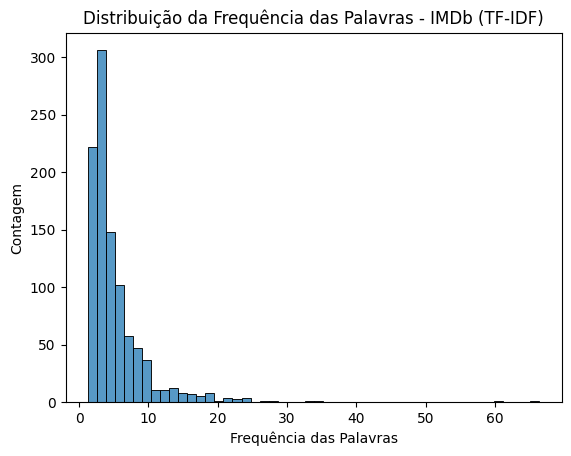

In [67]:
# Plotagem da distribuição da frequência das palavras
def plot_tfidf_word_distribution(tfidf_matrix, title):
    word_freq = np.ravel(tfidf_matrix.sum(axis=0))
    sns.histplot(word_freq, bins=50)
    plt.title(title)
    plt.xlabel('Frequência das Palavras')
    plt.ylabel('Contagem')
    plt.show()

plot_tfidf_word_distribution(X_train_tfidf_imdb, 'Distribuição da Frequência das Palavras - IMDb (TF-IDF)')

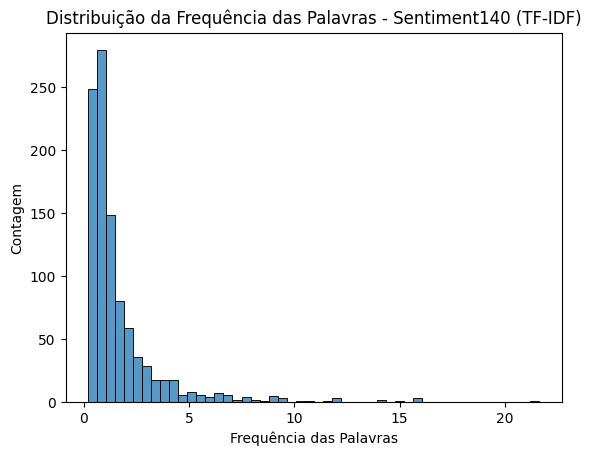

In [68]:
plot_tfidf_word_distribution(X_train_tfidf_sentiment140, 'Distribuição da Frequência das Palavras - Sentiment140 (TF-IDF)')

Word2Vec

Treinamento do modelo com Word2Vec
Transformação de reviews em embeddings
Plotagem da distribuição dos embeddings.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


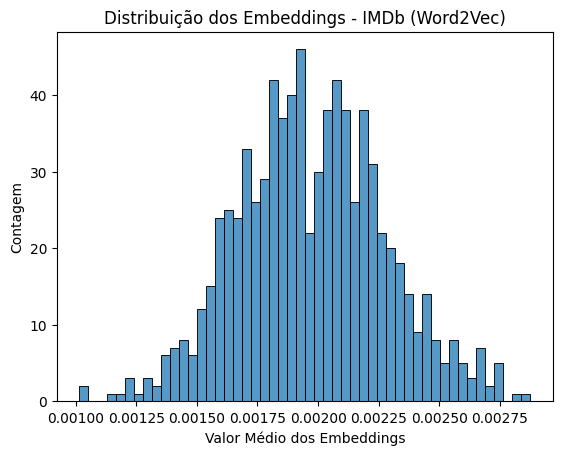

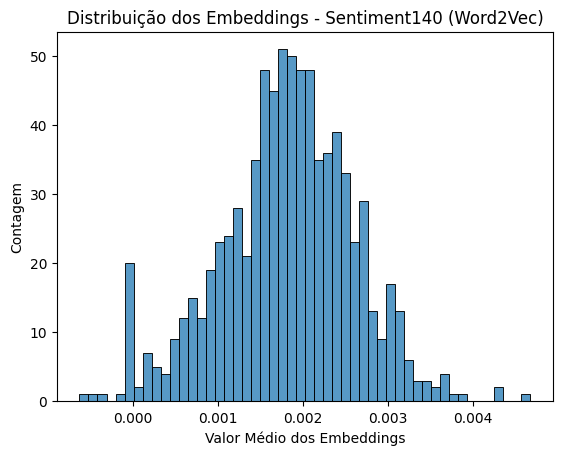

In [69]:
# Tokenização das sentenças
def tokenize_sentences(sentences):
    return [gensim.utils.simple_preprocess(sentence) for sentence in sentences]

# Treinar modelo Word2Vec
sentences = tokenize_sentences(X_train_imdb)
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Função para obter o vetor médio das palavras
def get_w2v_vectors(model, sentences):
    vectors = []
    for sentence in sentences:
        words = gensim.utils.simple_preprocess(sentence)
        vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
        if isinstance(vector, np.ndarray):
            vectors.append(vector)
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

# IMDb
X_train_w2v_imdb = get_w2v_vectors(w2v_model, X_train_imdb)
X_test_w2v_imdb = get_w2v_vectors(w2v_model, X_test_imdb)

# Sentiment140
X_train_w2v_sentiment140 = get_w2v_vectors(w2v_model, X_train_sentiment140)
X_test_w2v_sentiment140 = get_w2v_vectors(w2v_model, X_test_sentiment140)

# Plotagem da distribuição dos embeddings
def plot_embedding_distribution(embeddings, title):
    mean_embeddings = np.mean(embeddings, axis=1)
    sns.histplot(mean_embeddings, bins=50)
    plt.title(title)
    plt.xlabel('Valor Médio dos Embeddings')
    plt.ylabel('Contagem')
    plt.show()

plot_embedding_distribution(X_train_w2v_imdb, 'Distribuição dos Embeddings - IMDb (Word2Vec)')
plot_embedding_distribution(X_train_w2v_sentiment140, 'Distribuição dos Embeddings - Sentiment140 (Word2Vec)')


GloVe

Foi realizado o pré-treinado GloVe e a transformação das reviews em embeddings
Plotagem da distribuição dos embeddings.

Atividade realizada com o objetivo de representar a distribuição

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


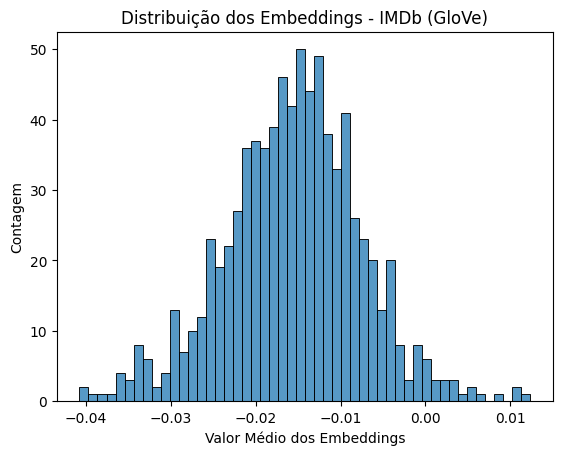

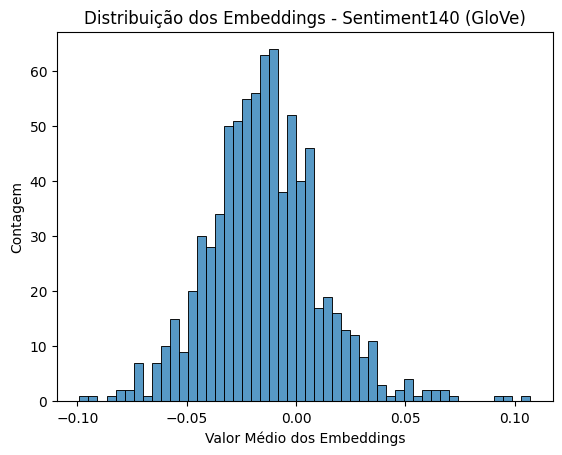

In [70]:
# Carregar modelo GloVe pré-treinado
glove_file = '/content/drive/MyDrive/Dados Compartilhados - f250/IFG/pln/glove.6B.100d.txt'
glove_model = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector

# Função para obter o vetor médio das palavras
def get_glove_vectors(model, sentences):
    vectors = []
    for sentence in sentences:
        words = gensim.utils.simple_preprocess(sentence)
        vector = np.mean([model[word] for word in words if word in model], axis=0)
        if isinstance(vector, np.ndarray):
            vectors.append(vector)
        else:
            vectors.append(np.zeros(100))
    return np.array(vectors)

# IMDb
X_train_glove_imdb = get_glove_vectors(glove_model, X_train_imdb)
X_test_glove_imdb = get_glove_vectors(glove_model, X_test_imdb)

# Sentiment140
X_train_glove_sentiment140 = get_glove_vectors(glove_model, X_train_sentiment140)
X_test_glove_sentiment140 = get_glove_vectors(glove_model, X_test_sentiment140)

# Plotagem da distribuição dos embeddings
plot_embedding_distribution(X_train_glove_imdb, 'Distribuição dos Embeddings - IMDb (GloVe)')
plot_embedding_distribution(X_train_glove_sentiment140, 'Distribuição dos Embeddings - Sentiment140 (GloVe)')


BERT

O objetivo do BERT está em transformar as reviews em embeddings

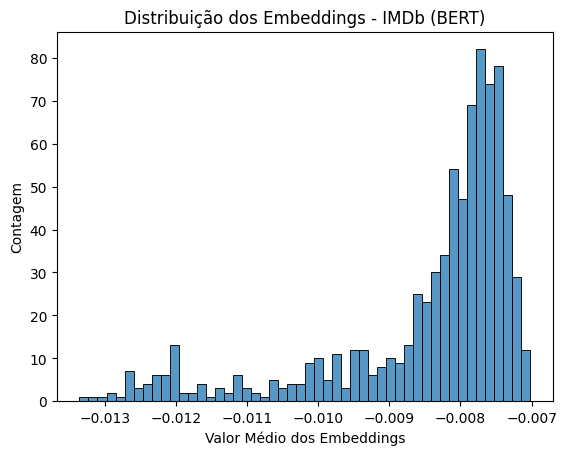

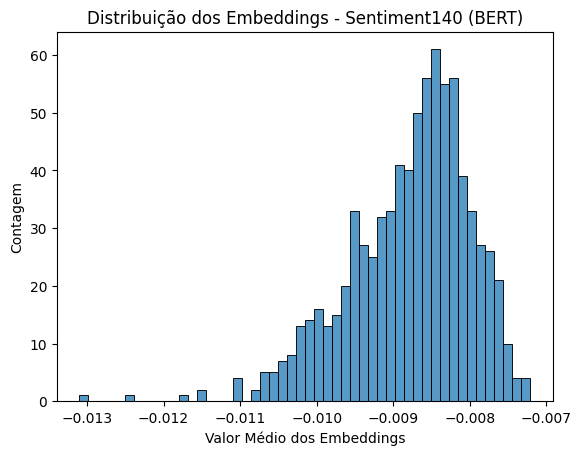

In [71]:
# Carregar tokenizer e modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Função para obter embeddings BERT
def get_bert_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

# IMDb
X_train_bert_imdb = get_bert_embeddings(X_train_imdb.tolist())
X_test_bert_imdb = get_bert_embeddings(X_test_imdb.tolist())

# Sentiment140
X_train_bert_sentiment140 = get_bert_embeddings(X_train_sentiment140.tolist())
X_test_bert_sentiment140 = get_bert_embeddings(X_test_sentiment140.tolist())

# Plotagem da distribuição dos embeddings
plot_embedding_distribution(X_train_bert_imdb, 'Distribuição dos Embeddings - IMDb (BERT)')
print('')
plot_embedding_distribution(X_train_bert_sentiment140, 'Distribuição dos Embeddings - Sentiment140 (BERT)')


A seguir será realizado o treinamento e o SVM será avaliado por cada embedding, as matrizes de confusão também serão apresentadas para verificação

In [72]:
# Plotagem da matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    plt.show()


In [73]:
# Resetar índices e remover valores NaN
#y_train_sentiment140 = y_train_sentiment140.reset_index(drop=True)
#y_train_sentiment140 = y_train_sentiment140.dropna()

# Sincronizar X_train_tfidf_sentiment140 com y_train_sentiment140
#X_train_tfidf_sentiment140 = X_train_tfidf_sentiment140[y_train_sentiment140.index]



In [90]:
# Converter os rótulos de string para valores binários
#y_train_imdb_bin = y_train_imdb.map({'positive': 1, 'negative': 0})
#y_test_imdb_bin = y_test_imdb.map({'positive': 1, 'negative': 0})


# Função para plotar a curva ROC
def plot_roc_curve(y_true, y_probs, title):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


IMDb TF-IDF Accuracy: 0.83
IMDb TF-IDF Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.79      0.84       114
    positive       0.76      0.88      0.82        86

    accuracy                           0.83       200
   macro avg       0.83      0.84      0.83       200
weighted avg       0.84      0.83      0.83       200



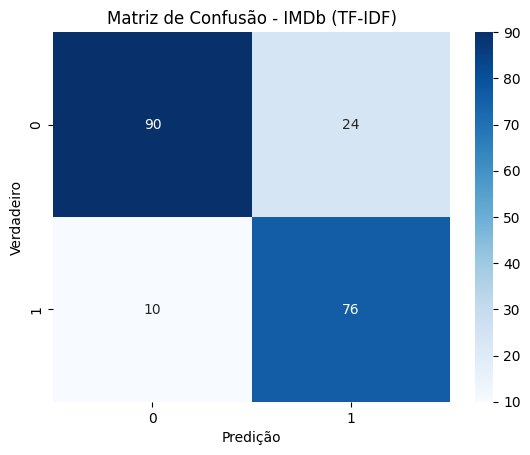

In [92]:
# Treinamento e avaliação com TF-IDF

# IMDb
model_tfidf_imdb = SVC(kernel='linear')
model_tfidf_imdb.fit(X_train_tfidf_imdb, y_train_imdb)
y_pred_tfidf_imdb = model_tfidf_imdb.predict(X_test_tfidf_imdb)
y_prob_tfidf_imdb = model_tfidf_imdb.decision_function(X_test_tfidf_imdb)


print("IMDb TF-IDF Accuracy:", accuracy_score(y_test_imdb, y_pred_tfidf_imdb))
print("IMDb TF-IDF Classification Report:\n", classification_report(y_test_imdb, y_pred_tfidf_imdb))

plot_confusion_matrix(y_test_imdb, y_pred_tfidf_imdb, 'Matriz de Confusão - IMDb (TF-IDF)')
#plot_roc_curve(y_test_imdb, y_prob_tfidf_imdb, 'Curva ROC - IMDb (TF-IDF)')


In [78]:
#plot_roc_curve(y_test_imdb_bin, y_prob_tfidf_imdb, 'Curva ROC - IMDb (TF-IDF)')

Sentiment140 TF-IDF Accuracy: 0.645
Sentiment140 TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61        94
           1       0.65      0.70      0.68       106

    accuracy                           0.65       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.65      0.64       200



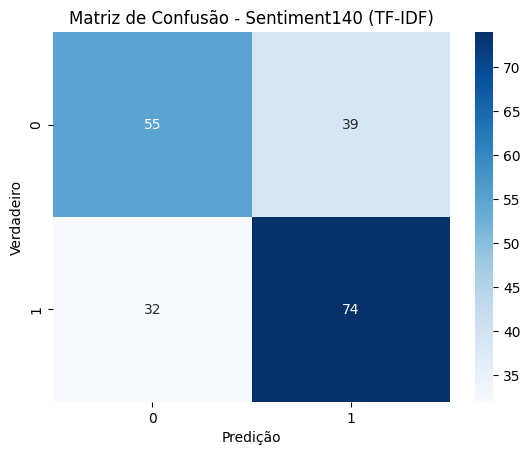

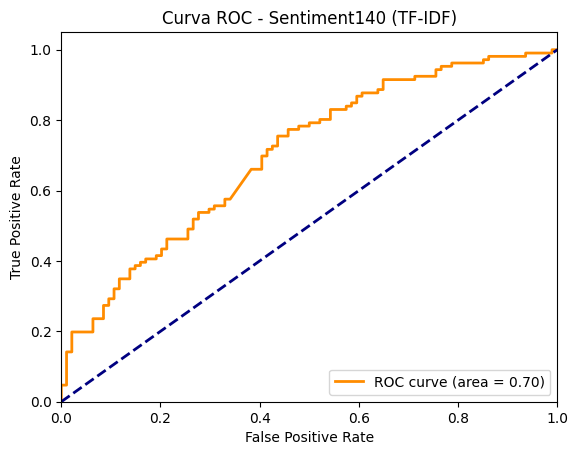

In [79]:
# Sentiment140
model_tfidf_sentiment140 = SVC(kernel='linear')
model_tfidf_sentiment140.fit(X_train_tfidf_sentiment140, y_train_sentiment140)
y_pred_tfidf_sentiment140 = model_tfidf_sentiment140.predict(X_test_tfidf_sentiment140)
y_prob_tfidf_sentiment140 = model_tfidf_sentiment140.decision_function(X_test_tfidf_sentiment140)

print("Sentiment140 TF-IDF Accuracy:", accuracy_score(y_test_sentiment140, y_pred_tfidf_sentiment140))
print("Sentiment140 TF-IDF Classification Report:\n", classification_report(y_test_sentiment140, y_pred_tfidf_sentiment140))

plot_confusion_matrix(y_test_sentiment140, y_pred_tfidf_sentiment140, 'Matriz de Confusão - Sentiment140 (TF-IDF)')
plot_roc_curve(y_test_sentiment140, y_prob_tfidf_sentiment140, 'Curva ROC - Sentiment140 (TF-IDF)')


Word2Vec


IMDb Word2Vec Accuracy: 0.57
IMDb Word2Vec Classification Report:
               precision    recall  f1-score   support

    negative       0.57      1.00      0.73       114
    positive       0.00      0.00      0.00        86

    accuracy                           0.57       200
   macro avg       0.28      0.50      0.36       200
weighted avg       0.32      0.57      0.41       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


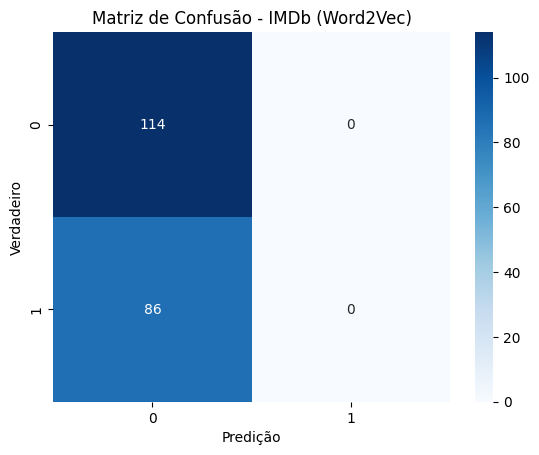

In [89]:
# Treinamento e avaliação com Word2Vec

# IMDb
model_w2v_imdb = SVC(kernel='linear')
model_w2v_imdb.fit(X_train_w2v_imdb, y_train_imdb)
y_pred_w2v_imdb = model_w2v_imdb.predict(X_test_w2v_imdb)
y_prob_w2v_imdb = model_w2v_imdb.decision_function(X_test_w2v_imdb)

print("IMDb Word2Vec Accuracy:", accuracy_score(y_test_imdb, y_pred_w2v_imdb))
print("IMDb Word2Vec Classification Report:\n", classification_report(y_test_imdb, y_pred_w2v_imdb))

# Plotagem da matriz de confusão
plot_confusion_matrix(y_test_imdb, y_pred_w2v_imdb, 'Matriz de Confusão - IMDb (Word2Vec)')
#plot_roc_curve(y_test_imdb, y_prob_w2v_imdb, 'Curva ROC - IMDb (Word2Vec)')


Sentiment140 Word2Vec Accuracy: 0.44
Sentiment140 Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.51      0.46        94
           1       0.47      0.38      0.42       106

    accuracy                           0.44       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.44      0.44      0.44       200



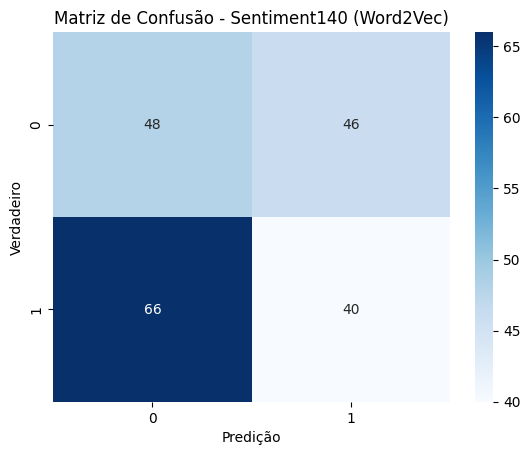

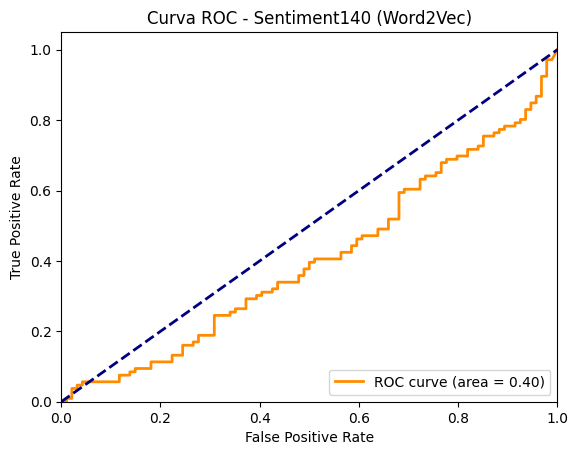

In [82]:

# Sentiment140
model_w2v_sentiment140 = SVC(kernel='linear')
model_w2v_sentiment140.fit(X_train_w2v_sentiment140, y_train_sentiment140)
y_pred_w2v_sentiment140 = model_w2v_sentiment140.predict(X_test_w2v_sentiment140)
y_prob_w2v_sentiment140 = model_w2v_sentiment140.decision_function(X_test_w2v_sentiment140)

print("Sentiment140 Word2Vec Accuracy:", accuracy_score(y_test_sentiment140, y_pred_w2v_sentiment140))
print("Sentiment140 Word2Vec Classification Report:\n", classification_report(y_test_sentiment140, y_pred_w2v_sentiment140))

plot_confusion_matrix(y_test_sentiment140, y_pred_w2v_sentiment140, 'Matriz de Confusão - Sentiment140 (Word2Vec)')
plot_roc_curve(y_test_sentiment140, y_prob_w2v_sentiment140, 'Curva ROC - Sentiment140 (Word2Vec)')


GloVe

IMDb GloVe Accuracy: 0.78
IMDb GloVe Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.79      0.80       114
    positive       0.73      0.77      0.75        86

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



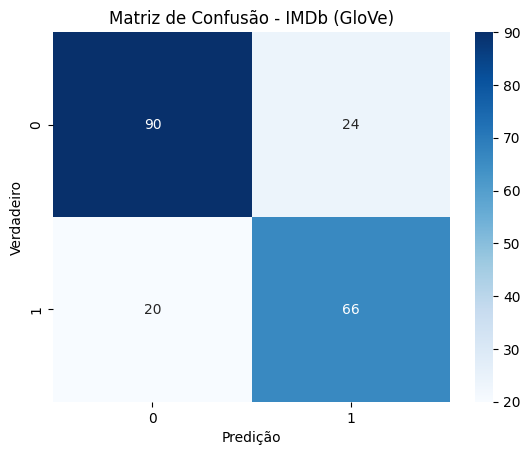

In [83]:
# Treinamento e avaliação com GloVe

# IMDb
model_glove_imdb = SVC(kernel='linear')
model_glove_imdb.fit(X_train_glove_imdb, y_train_imdb)
y_pred_glove_imdb = model_glove_imdb.predict(X_test_glove_imdb)
y_prob_glove_imdb = model_glove_imdb.decision_function(X_test_glove_imdb)

print("IMDb GloVe Accuracy:", accuracy_score(y_test_imdb, y_pred_glove_imdb))
print("IMDb GloVe Classification Report:\n", classification_report(y_test_imdb, y_pred_glove_imdb))

plot_confusion_matrix(y_test_imdb, y_pred_glove_imdb, 'Matriz de Confusão - IMDb (GloVe)')
#plot_roc_curve(y_test_imdb, y_prob_glove_imdb, 'Curva ROC - IMDb (GloVe)')

Sentiment140 GloVe Accuracy: 0.59
Sentiment140 GloVe Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        94
           1       0.62      0.59      0.61       106

    accuracy                           0.59       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.59      0.59      0.59       200



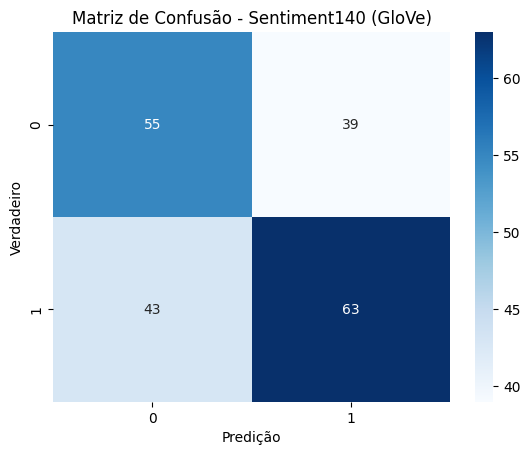

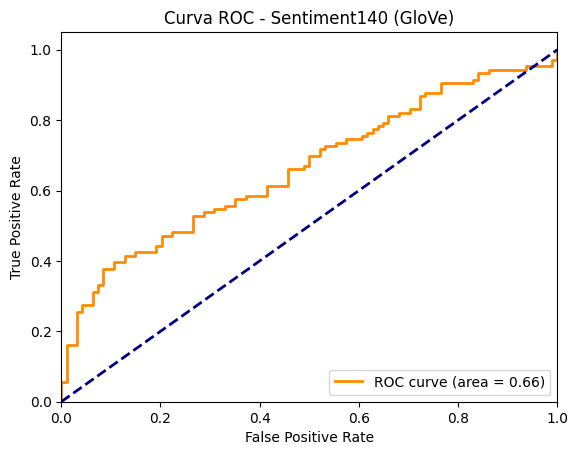

In [85]:
# Sentiment140
model_glove_sentiment140 = SVC(kernel='linear')
model_glove_sentiment140.fit(X_train_glove_sentiment140, y_train_sentiment140)
y_pred_glove_sentiment140 = model_glove_sentiment140.predict(X_test_glove_sentiment140)
y_prob_glove_sentiment140 = model_glove_sentiment140.decision_function(X_test_glove_sentiment140)

print("Sentiment140 GloVe Accuracy:", accuracy_score(y_test_sentiment140, y_pred_glove_sentiment140))
print("Sentiment140 GloVe Classification Report:\n", classification_report(y_test_sentiment140, y_pred_glove_sentiment140))

# Plotagem da matriz de confusão
plot_confusion_matrix(y_test_sentiment140, y_pred_glove_sentiment140, 'Matriz de Confusão - Sentiment140 (GloVe)')
plot_roc_curve(y_test_sentiment140, y_prob_glove_sentiment140, 'Curva ROC - Sentiment140 (GloVe)')


Bert

IMDb BERT Accuracy: 0.76
IMDb BERT Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.82      0.79       114
    positive       0.74      0.69      0.71        86

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.76       200



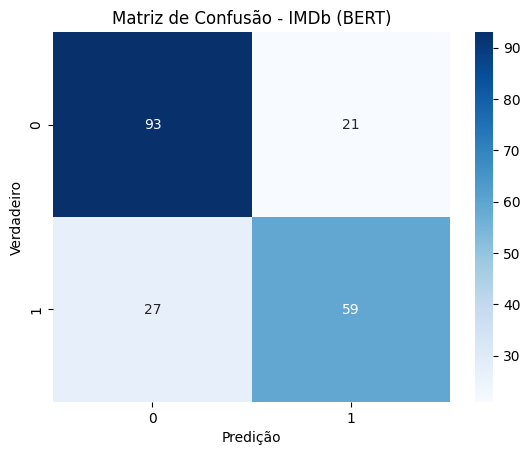

In [86]:
# Treinamento e avaliação com BERT

# IMDb
model_bert_imdb = SVC(kernel='linear')
model_bert_imdb.fit(X_train_bert_imdb, y_train_imdb)
y_pred_bert_imdb = model_bert_imdb.predict(X_test_bert_imdb)
y_prob_bert_imdb = model_bert_imdb.decision_function(X_test_bert_imdb)

print("IMDb BERT Accuracy:", accuracy_score(y_test_imdb, y_pred_bert_imdb))
print("IMDb BERT Classification Report:\n", classification_report(y_test_imdb, y_pred_bert_imdb))

plot_confusion_matrix(y_test_imdb, y_pred_bert_imdb, 'Matriz de Confusão - IMDb (BERT)')
#plot_roc_curve(y_test_imdb, y_prob_bert_imdb, 'Curva ROC - IMDb (BERT)')


Sentiment140 BERT Accuracy: 0.615
Sentiment140 BERT Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.59        94
           1       0.64      0.63      0.64       106

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.62      0.61      0.62       200



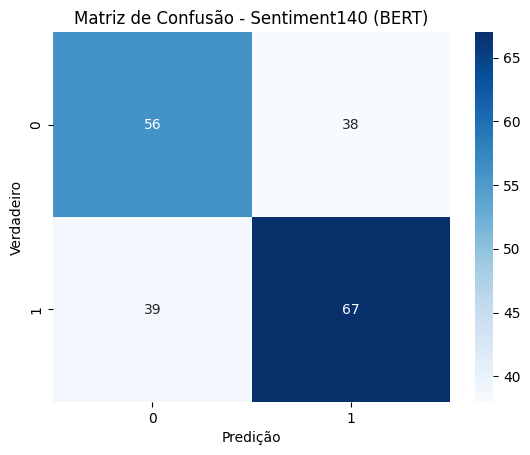

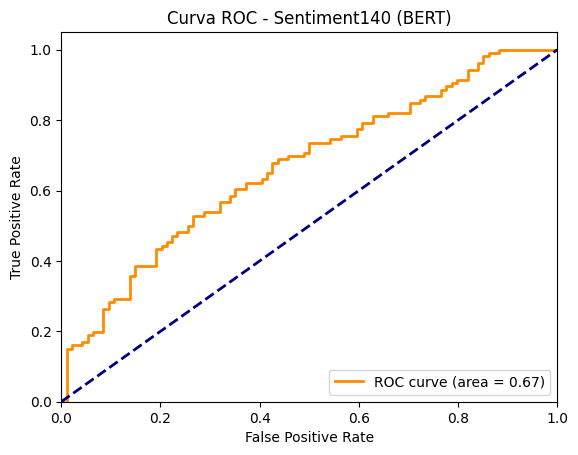

In [87]:
# Sentiment140
model_bert_sentiment140 = SVC(kernel='linear')
model_bert_sentiment140.fit(X_train_bert_sentiment140, y_train_sentiment140)
y_pred_bert_sentiment140 = model_bert_sentiment140.predict(X_test_bert_sentiment140)
y_prob_bert_sentiment140 = model_bert_sentiment140.decision_function(X_test_bert_sentiment140)

print("Sentiment140 BERT Accuracy:", accuracy_score(y_test_sentiment140, y_pred_bert_sentiment140))
print("Sentiment140 BERT Classification Report:\n", classification_report(y_test_sentiment140, y_pred_bert_sentiment140))

# Plotagem da matriz de confusão

plot_confusion_matrix(y_test_sentiment140, y_pred_bert_sentiment140, 'Matriz de Confusão - Sentiment140 (BERT)')
plot_roc_curve(y_test_sentiment140, y_prob_bert_sentiment140, 'Curva ROC - Sentiment140 (BERT)')


.
.
.
.
.
.

---

.
.
.
.
.
.



**A seguir está sendo apresentado a implementação que foi realizada inicialmente, apresentada no dia 31/07**

In [ ]:
# Instalação do pacote emoji (caso necessário)
!pip install emoji

# Instalação da biblioteca transformers e datasets
!pip install transformers
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch

# Verifica se há uma GPU disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# Importação das bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import emoji
import re

# Download de recursos NLTK
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

# Função de pré-processamento de texto
def preprocess_text(text):
    """
    Função para pré-processar o texto:
    - Converte para minúsculas
    - Substitui emojis por descrições textuais
    - Remove URLs
    - Remove tags HTML
    - Remove caracteres especiais
    - Tokeniza o texto
    - Remove stopwords
    - Aplica stemming
    """
    text = text.lower()  # Converte para minúsculas
    text = emoji.demojize(text)  # Converte emojis para descrições textuais
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove tags HTML
    text = re.sub(r'[^a-z\s]', '', text)  # Remove caracteres especiais
    tokens = nltk.word_tokenize(text)  # Tokeniza o texto
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()  # Inicializa o stemmer
    tokens = [stemmer.stem(word) for word in tokens]  # Aplica stemming
    return ' '.join(tokens)  # Junta tokens em uma string


In [ ]:

# -------------------------------------
# Carregamento e pré-processamento dos dados IMDb
# -------------------------------------
# Carregamento dos dados IMDb
imdb_data = pd.read_csv('/content/drive/MyDrive/IFG/4 Período/PLN/Trabalho final/IMDB Dataset.csv')
imdb_data = imdb_data.sample(n=1000, random_state=42)

# Visualização das primeiras linhas do dataset IMDb
print("Primeiras linhas do dataset IMDb:")
print(imdb_data.head())


Primeiras linhas do dataset IMDb:
                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative


In [ ]:

# Pré-processamento dos dados IMDb
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)
imdb_data['sentiment'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

# Divisão dos dados em treino e teste
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(imdb_data['review'], imdb_data['sentiment'], test_size=0.2, random_state=42)


In [ ]:

# Vetorização com TF-IDF
vectorizer_imdb = TfidfVectorizer(max_features=1000)
X_train_tfidf_imdb = vectorizer_imdb.fit_transform(X_train_imdb)
X_test_tfidf_imdb = vectorizer_imdb.transform(X_test_imdb)

# Treinamento do modelo SVM para IMDb
model_imdb = SVC(kernel='linear')
model_imdb.fit(X_train_tfidf_imdb, y_train_imdb)

# Previsões e avaliação para IMDb
y_pred_imdb = model_imdb.predict(X_test_tfidf_imdb)
print('Acurácia (IMDb):', accuracy_score(y_test_imdb, y_pred_imdb))
print(classification_report(y_test_imdb, y_pred_imdb))


Accuracy (IMDb): 0.839
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       506
           1       0.81      0.88      0.84       494

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [ ]:

# -------------------------------------
# Carregamento e pré-processamento dos dados Sentiment140
# -------------------------------------
# Carregamento dos dados Sentiment140
sentiment140_data = pd.read_csv('/content/drive/MyDrive/IFG/4 Período/PLN/Trabalho final/twitter.csv', encoding='latin-1', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'])
sentiment140_data = sentiment140_data.sample(n=1000, random_state=42)  # Limitar a 5000 registros para evitar sobrecarga

# Visualização das primeiras linhas do dataset Sentiment140
print("Primeiras linhas do dataset Sentiment140:")
print(sentiment140_data.head())


Primeiras linhas do dataset Sentiment140:
        sentiment          id                          date     query  \
541200          0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750             0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711          0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055          0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995          0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750         sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
766711       sammydearr  @TiannaChaos i know  just family drama. its la...  
285055      Lamb_Leanne  School email won't open  and I have geography ...  
705995      yogicerdito                             upper airways problem   


In [ ]:

# Pré-processamento dos dados Sentiment140
sentiment140_data['text'] = sentiment140_data['text'].apply(preprocess_text)
sentiment140_data['sentiment'] = sentiment140_data['sentiment'].map({0: 0, 4: 1})

# Divisão dos dados em treino e teste
X_train_sent140, X_test_sent140, y_train_sent140, y_test_sent140 = train_test_split(sentiment140_data['text'], sentiment140_data['sentiment'], test_size=0.2, random_state=42)

# Vetorização com TF-IDF
vectorizer_sent140 = TfidfVectorizer(max_features=1000)
X_train_tfidf_sent140 = vectorizer_sent140.fit_transform(X_train_sent140)
X_test_tfidf_sent140 = vectorizer_sent140.transform(X_test_sent140)

# Treinamento do modelo SVM para Sentiment140
model_sent140 = SVC(kernel='linear')
model_sent140.fit(X_train_tfidf_sent140, y_train_sent140)

# Previsões e avaliação para Sentiment140
y_pred_sent140 = model_sent140.predict(X_test_tfidf_sent140)
print('Acurácia (Twitter):', accuracy_score(y_test_sent140, y_pred_sent140))
print(classification_report(y_test_sent140, y_pred_sent140))


Accuracy (Sentiment140): 0.697
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       496
           1       0.70      0.71      0.70       504

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



Classification Report IMDb:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       506
           1       0.81      0.88      0.84       494

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



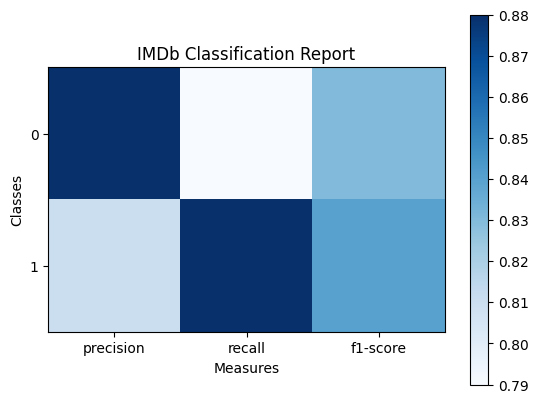

In [ ]:

# -------------------------------------
# Visualização dos resultados
# -------------------------------------
def plot_classification_report(report, title='Report de classificação ', with_avg_total=False, cmap=plt.cm.Blues):
    """
    Função para plotar o relatório de classificação
    """
    lines = report.split('\n')

    classes = []
    plotMat = []
    for line in lines[2: (len(lines) - 5)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = ['precision', 'recall', 'f1-score']
    y_tick_marks = classes
    plt.xticks(np.arange(len(x_tick_marks)), x_tick_marks)
    plt.yticks(np.arange(len(y_tick_marks)), y_tick_marks)

    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

# Plotando resultados para IMDb
imdb_report = classification_report(y_test_imdb, y_pred_imdb)
print("Report de classificação IMDb:\n", imdb_report)
plot_classification_report(imdb_report, title='IMDb Report de Classificação')


Classification Report Sentiment140:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69       496
           1       0.70      0.71      0.70       504

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



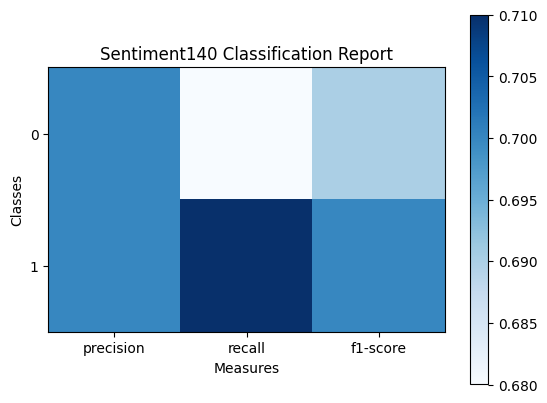

In [ ]:

# Plotando resultados para Sentiment140
sent140_report = classification_report(y_test_sent140, y_pred_sent140)
print("Report de classificação Twitter:\n", sent140_report)
plot_classification_report(sent140_report, title='Report de classificação Twitter')


Através da acurácia medimos a proporção de previsões corretas em relação ao total de casos avaliados;

A precisão é a proporção de verdadeiros positivos, com uma alta precisão temos poucos falsos positivos;

O Recall é a proporção de verdadeiros positivos em relação ao total de casos realmente positivos. Alto recall significa poucos falsos negativos;

O F1-score é a média harmônica da precisão e do recall.

Comparando resultados dos modelos...
Visualizando resultados comparativos...


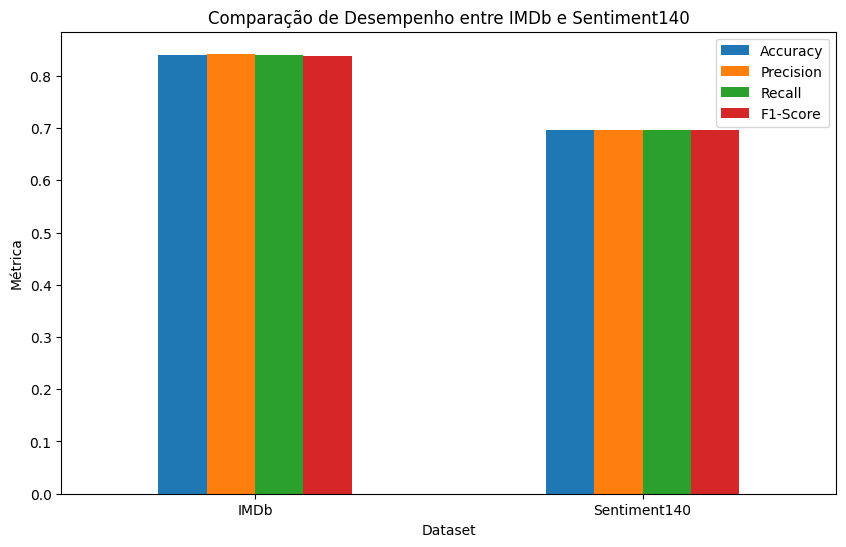

Resultados comparativos:
        Dataset  Accuracy  Precision  Recall  F1-Score
0          IMDb     0.839   0.842199   0.839  0.838735
1  Sentiment140     0.697   0.697042   0.697  0.696937


In [ ]:

# -------------------------------------
# Comparação dos resultados
# -------------------------------------
print("Comparando resultados dos modelos...")
results = {
    'Dataset': ['IMDb', 'Sentiment140'],
    'Accuracy': [accuracy_score(y_test_imdb, y_pred_imdb), accuracy_score(y_test_sent140, y_pred_sent140)],
    'Precision': [classification_report(y_test_imdb, y_pred_imdb, output_dict=True)['weighted avg']['precision'],
                  classification_report(y_test_sent140, y_pred_sent140, output_dict=True)['weighted avg']['precision']],
    'Recall': [classification_report(y_test_imdb, y_pred_imdb, output_dict=True)['weighted avg']['recall'],
               classification_report(y_test_sent140, y_pred_sent140, output_dict=True)['weighted avg']['recall']],
    'F1-Score': [classification_report(y_test_imdb, y_pred_imdb, output_dict=True)['weighted avg']['f1-score'],
                 classification_report(y_test_sent140, y_pred_sent140, output_dict=True)['weighted avg']['f1-score']]
}

results_df = pd.DataFrame(results)

# Visualização dos resultados comparativos
print("Visualizando resultados comparativos...")
results_df.set_index('Dataset').plot(kind='bar', figsize=(10, 6))
plt.title('Comparação de Desempenho entre IMDb e Sentiment140')
plt.ylabel('Métrica')
plt.xticks(rotation=0)
plt.show()

print("Resultados comparativos:")
print(results_df)

Análise com Matriz de Confusão

Apresenta como os modelos estão classificando corretamente ou incorretamente as classes.


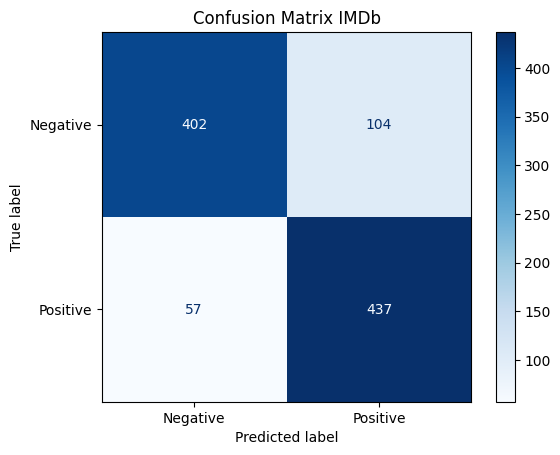

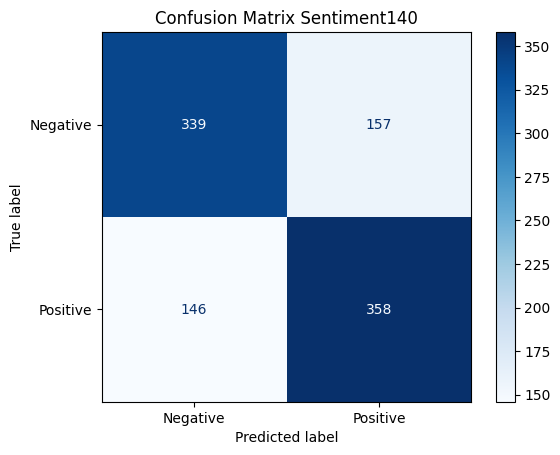

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de Confusão para IMDb
cm_imdb = confusion_matrix(y_test_imdb, y_pred_imdb)
disp_imdb = ConfusionMatrixDisplay(confusion_matrix=cm_imdb, display_labels=['Negative', 'Positive'])
disp_imdb.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusão IMDb')
plt.show()

# Matriz de Confusão para Sentiment140
cm_sent140 = confusion_matrix(y_test_sent140, y_pred_sent140)
disp_sent140 = ConfusionMatrixDisplay(confusion_matrix=cm_sent140, display_labels=['Negative', 'Positive'])
disp_sent140.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusão Sentiment140')
plt.show()


Curva ROC e AUC

Avaliar a performance dos modelos em diferentes limiares de decisão.

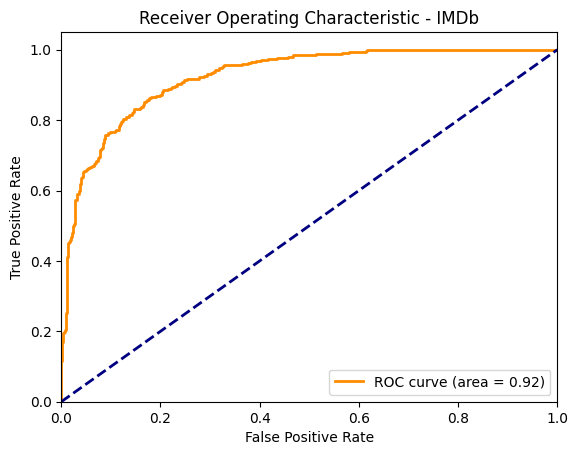

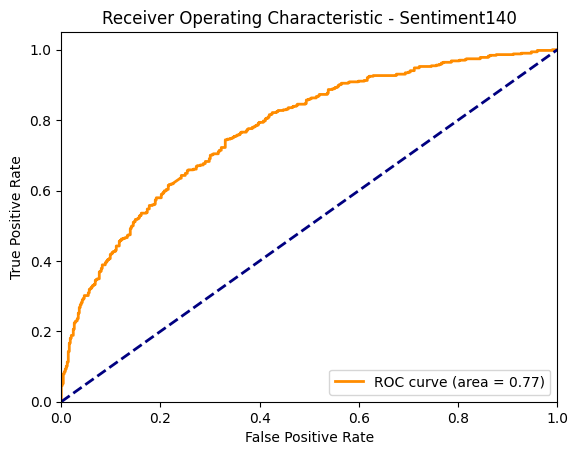

In [ ]:


from sklearn.metrics import roc_curve, auc

# Curva ROC e AUC para IMDb
fpr_imdb, tpr_imdb, _ = roc_curve(y_test_imdb, model_imdb.decision_function(X_test_tfidf_imdb))
roc_auc_imdb = auc(fpr_imdb, tpr_imdb)
plt.figure()
plt.plot(fpr_imdb, tpr_imdb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_imdb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - IMDb')
plt.legend(loc="lower right")
plt.show()

# Curva ROC e AUC para Sentiment140
fpr_sent140, tpr_sent140, _ = roc_curve(y_test_sent140, model_sent140.decision_function(X_test_tfidf_sent140))
roc_auc_sent140 = auc(fpr_sent140, tpr_sent140)
plt.figure()
plt.plot(fpr_sent140, tpr_sent140, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sent140)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Sentiment140')
plt.legend(loc="lower right")
plt.show()


Análise de Feature Importance

Através da análise é possível visualizar quais palavras (features) são mais importantes para a classificação. Permite ser avaliado através da examinação  dos coeficientes do modelo SVM

Palavras mais importantes - IMDb


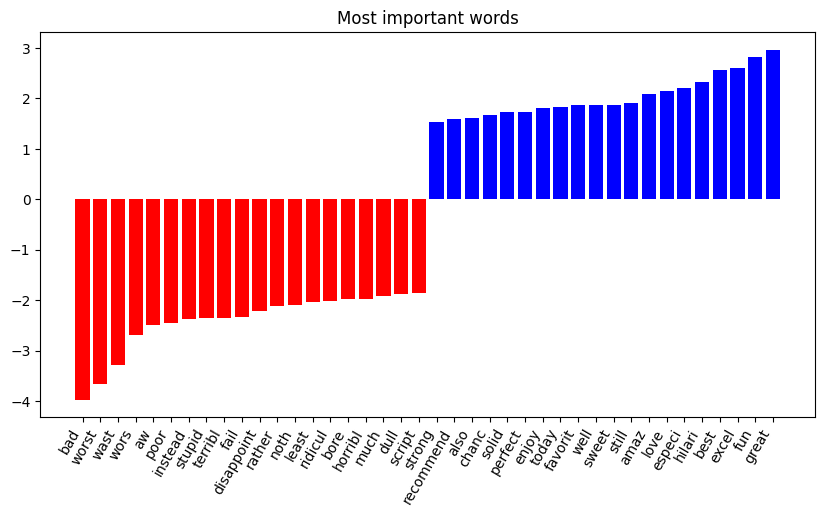

Palavras mais importantes - Twitter


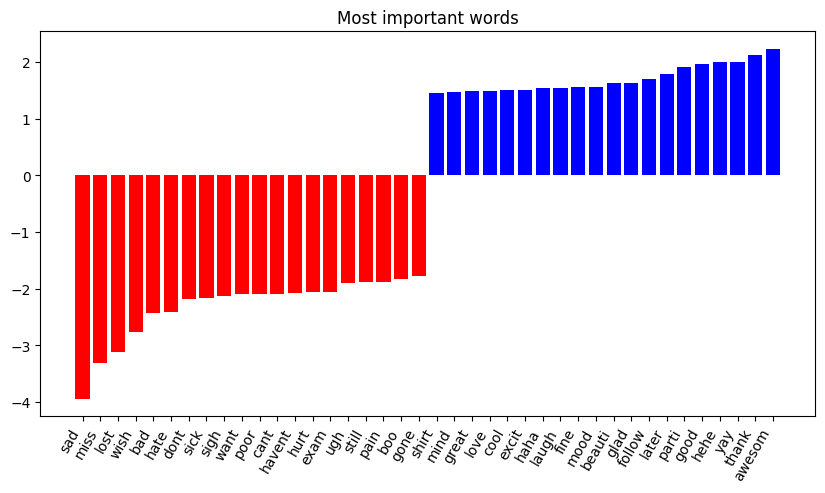

In [ ]:
# Função para plotar as palavras mais importantes
def plot_most_important_words(vectorizer, model, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_.toarray().flatten()
    top_positive_coefficients = np.argsort(coef)[-top_n:]
    top_negative_coefficients = np.argsort(coef)[:top_n]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_n), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2 * top_n), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Most important words')
    plt.show()

print('Palavras mais importantes - IMDb')
# Plotando palavras mais importantes para IMDb
plot_most_important_words(vectorizer_imdb, model_imdb)

print('Palavras mais importantes - Twitter')
# Plotando palavras mais importantes para Sentiment140
plot_most_important_words(vectorizer_sent140, model_sent140)


Cross-Validation

Avaliação da robustez do modelo em diferentes subconjuntos dos dados.

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation para IMDb
scores_imdb = cross_val_score(model_imdb, X_train_tfidf_imdb, y_train_imdb, cv=5, scoring='accuracy')
print("Cross-validation scores (IMDb):", scores_imdb)
print("Mean cross-validation score (IMDb):", scores_imdb.mean())

# Cross-validation para Sentiment140
scores_sent140 = cross_val_score(model_sent140, X_train_tfidf_sent140, y_train_sent140, cv=5, scoring='accuracy')
print("Cross-validation scores (Sentiment140):", scores_sent140)
print("Mean cross-validation score (Sentiment140):", scores_sent140.mean())


Cross-validation scores (IMDb): [0.8325  0.84625 0.85375 0.84625 0.8275 ]
Mean cross-validation score (IMDb): 0.8412499999999999
Cross-validation scores (Sentiment140): [0.7225  0.7     0.7025  0.71375 0.71125]
Mean cross-validation score (Sentiment140): 0.7100000000000001


Testes de Hipóteses

Teste estatísticos realizado para comparar os desempenhos dos modelos de maneira formal.

In [ ]:
from scipy.stats import ttest_ind

# Realizar previsões em cross-validation
cross_val_pred_imdb = cross_val_score(model_imdb, X_test_tfidf_imdb, y_test_imdb, cv=5)
cross_val_pred_sent140 = cross_val_score(model_sent140, X_test_tfidf_sent140, y_test_sent140, cv=5)

# Teste t para comparar as acurácias dos modelos
t_stat, p_val = ttest_ind(cross_val_pred_imdb, cross_val_pred_sent140)
print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: 10.78186479855516, P-value: 4.8256436705300735e-06


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Naive Bayes
#algoritmo de classificação probabilística baseado no teorema de Bayes, que pressupõe que as características são independentes umas das outras, dado a classe.
nb_model_imdb = MultinomialNB()
nb_model_imdb.fit(X_train_tfidf_imdb, y_train_imdb)
y_pred_nb_imdb = nb_model_imdb.predict(X_test_tfidf_imdb)

nb_model_sent140 = MultinomialNB()
nb_model_sent140.fit(X_train_tfidf_sent140, y_train_sent140)
y_pred_nb_sent140 = nb_model_sent140.predict(X_test_tfidf_sent140)

# Random Forest
#algoritmo de aprendizado de máquina baseado em um conjunto de árvores de decisão. Ele cria múltiplas árvores de decisão durante a fase de treinamento e utiliza a média das previsões de cada árvore para melhorar a precisão e controlar o overfitting.
rf_model_imdb = RandomForestClassifier()
rf_model_imdb.fit(X_train_tfidf_imdb, y_train_imdb)
y_pred_rf_imdb = rf_model_imdb.predict(X_test_tfidf_imdb)

rf_model_sent140 = RandomForestClassifier()
rf_model_sent140.fit(X_train_tfidf_sent140, y_train_sent140)
y_pred_rf_sent140 = rf_model_sent140.predict(X_test_tfidf_sent140)

# Avaliação dos novos modelos
print('Accuracy (Naive Bayes IMDb):', accuracy_score(y_test_imdb, y_pred_nb_imdb))
print(classification_report(y_test_imdb, y_pred_nb_imdb))

print('Accuracy (Naive Bayes Sentiment140):', accuracy_score(y_test_sent140, y_pred_nb_sent140))
print(classification_report(y_test_sent140, y_pred_nb_sent140))

print('Accuracy (Random Forest IMDb):', accuracy_score(y_test_imdb, y_pred_rf_imdb))
print(classification_report(y_test_imdb, y_pred_rf_imdb))

print('Accuracy (Random Forest Sentiment140):', accuracy_score(y_test_sent140, y_pred_rf_sent140))
print(classification_report(y_test_sent140, y_pred_rf_sent140))


Accuracy (Naive Bayes IMDb): 0.836
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       506
           1       0.84      0.83      0.83       494

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Accuracy (Naive Bayes Sentiment140): 0.709
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       496
           1       0.73      0.66      0.70       504

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000

Accuracy (Random Forest IMDb): 0.822
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       506
           1       0.82      0.81      0.82       494

    accuracy                           0.82      1000
   macro avg 